In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.optimize import curve_fit

%matplotlib inline

### Loading Data

Load in the columns from the Electro Thermal Mechanical Tester (ETMT) data file. The ETMT data file is typically called something like `Test1.steps.tracking.csv`. The columns recording the ETMT data in the file may be organised and labelled differently depending on which ETMT you have used and how the output was setup in the method.

*Note, in python the first column is zero.*

In [2]:
# use this cell for the data inputs for the Manchester ETMT and Diamond data collected in 2017

# give the dimensions of the sample in millimetres
length = 2 # note, this is the distance between resistivity wires, usually 2 mm
thickness = 2
width = 2

# identify the columns to upload from the file
use_columns = (0,7,8,9,10,11,12,13,15)

# relate each of the columns in the use_columns list
column = {  "time": 0, # time in Seconds
            "position" : 1, # position / displacement in Millimetres
            "load" : 2, # load in Newtons
            "current" : 3, # current in Amps
            "temperature" : 4, # temperature in Celsius recoded at ETMT
            "voltage" : 5, # voltage in Volts
            "temperature_eurotherm" : 6, # temperature in Celsius recoded at Eurotherm
            "frame" : 7 # frame signal
            }

# provide the relative filepath to the ETMT data file
input_filepath = "../../SXRD_raw_data/diamond_2017/rawdata_ETMT/045_2Nb_TDheat_1100C_5Cs/Test1/Test1.steps.tracking.csv"

In [ ]:
# use this cell for the data inputs for the Diamond data collected in 2021

# give the dimensions of the sample in millimetres
length = 2 # note, this is the distance between resistivity wires, usually 2 mm
thickness = 2
width = 4

# identify the columns to upload from the file
use_columns = (0,7,8,10,11,12,13,14)

column = {  "time": 0, # time in Seconds
            "position" : 1, # position / displacement in Millimetres
            "load" : 2, # load in Newtons
            "current" : 3, # current in Amps
            "temperature" : 4, # temperature in Celsius recoded at ETMT
            "voltage" : 5, # voltage in Volts
            "temperature_eurotherm" : 6, # temperature in Celsius recoded at Eurotherm
            "frame" : 7 # frame signal
            }

# provide the relative filepath to the ETMT data file
input_filepath = "../../SXRD_raw_data/diamond_2021_fast_detector/rawdata_ETMT/006_Ti64_TD_Heat_Temp_1200C_Rate_2-5Cs/Test1/Test1.steps.tracking.csv"

In [ ]:
# use this cell for the data inputs for the Diamond data collected in 2022

# give the dimensions of the sample in millimetres
length = 2 # note, this is the distance between resistivity wires, usually 2 mm
thickness = 2
width = 4

# identify the columns to upload from the file
use_columns = (0,8,11,16,14,17,15,19)

column = {  "time": 0, # time in Seconds
            "position" : 1, # position / displacement in Millimetres
            "load" : 2, # load in Newtons
            "current" : 3, # current in Amps
            "temperature" : 4, # temperature in Celsius recoded at ETMT
            "voltage" : 5, # voltage in Volts
            "temperature_eurotherm" : 6, # temperature in Celsius recoded at Eurotherm
            "frame" : 7 # frame signal
            }

# provide the relative filepath to the ETMT data file
input_filepath = "../../SXRD_raw_data/diamond_2022/rawdata_ETMT/033_Ti64_TIFUN-T6_Heat_1200C_1Cs-1/Test1/Test1.steps.tracking.csv"

This next cell uses the inputs defined above to load the data into an array, which we can then use to analyse and plot our ETMT data.

In [3]:
ETMT_data_array = np.loadtxt(input_filepath, skiprows=1, delimiter=',', usecols = use_columns)
ETMT_data_array = ETMT_data_array.T

### Calculating the ${\beta}$ Approach Curve

The change in phase fraction is calculated from the change in overall resistivity as we heat the sample. This is possible since the resitivity response of each phase to applied current will be different. The theory for this approach is briefly described in this [EngD Thesis by Christopher S. Daniel](https://www.research.manchester.ac.uk/portal/en/theses/an-investigation-into-the-texture-development-during-hotrolling-of-dualphase-zirconium-alloys(416cf1d6-15de-41d0-ad7c-3d0db664ae84).html). The theory was originally derived by Fan et al. in this [paper](https://doi.org/10.1016/0956-7151(95)90259-7)

Remember that;

**Resistance** is equal to **Voltage** divided by **Current**;

${R = V / I}$

**Electrical Resistivity** is equal to **Resistance** times by **Area** divided by the **Length**

${\rho = RA / L}$

**Conductivity** is equal to one over the **Electrical Resistivity**;

${\sigma = 1 / \rho}$

The current is the overall current supplied by the ETMT to heat the sample. The voltage is measured between the two resistivity wires, typically welded with a gap of 2 mm. *Note, you do not have to measure this distance accurately, it will affect the calculated resistivity value, but it will not affect the phase fraction or final approach curve.* 

The cell below calculates the resitivity and conductivity based on the inputs already given and using the dimensions of the sample.

In [4]:
area = thickness*width

print("The area of the sample is: ", area, 'mm squared')
print("The length between the resistivity wires is: ", length, "mm")

# voltage_filtered = medfilt(ETMT_data_array[column["voltage"]], 101)

resistance = np.divide(ETMT_data_array[column["voltage"]], ETMT_data_array[column["current"]])

resistivity = (resistance * area) / length

conductivity = 1 / resistivity

The area of the sample is:  4 mm squared
The length between the resistivity wires is:  2 mm


Because the start of the ETMT data can be noisey it is worth excluding the first values in the data file, below ${100 ^\circ C}$. We also want to look at heating and cooling data separately, so for heating we are interested in looking at data up to the maximum temperature.

So, let's reduce the data within those parameters to define a `start` and `end` value, which we will use to define the arrays covering just the heating of the sample.

In [5]:
# adjust this value to cut off results below a given temperature, 100 degrees celsius is default
min_temperature_value = 100

In [6]:
length_array = np.shape(ETMT_data_array)
print("The total length of the array is ", length_array[1], "elements.")

absolute_temperature_value = np.abs(ETMT_data_array[column["temperature"]] - min_temperature_value)
min_element = absolute_temperature_value.argmin()
print("The minimum temperature value has been set to: ", min_temperature_value, ", which is element ", min_element, "in the array.")

max_value = max(ETMT_data_array[column["temperature"]])
max_element = (ETMT_data_array[column["temperature"]]).argmax()
print("The maximum temperature value has been found to be: ", max_value, ", which is element ", max_element, "in the array.")

start = min_element
end = max_element

The total length of the array is  24861 elements.
The minimum temperature value has been set to:  100 , which is element  3244 in the array.
The maximum temperature value has been found to be:  1096.99703659862 , which is element  13904 in the array.


In single-phase Zr or Ti alloys, it is expected that; 

- alpha-phase resistivity should follow a cubic trend with temperature.
- beta-phase resistivity should follow a linear trend with temperature.

In single-phase Zr or Ti alloys, the start of the transition from alpha to beta phase is defined by a sharp transition at which the +ve gradient of the resisivity curve in the alpha-regime, ${d\rho/dT}$, becomes zero. Likewise, the end of the transition from mixed alpha/beta to fully beta phase, is when the -ve gradient of the resistivity curve in the mixed-phase regime becomes zero - **this defines the full ${\beta}$ transus temperature.**

In two-phase alloys such as Zr-2.5Nb and Ti-64, which already contain some beta phase at room temperature, the start of the alpha to beta transus is much more gradual, since the phases are already mixed. Therefore, it is much more difficult to define an exact start of the transition, when more beta-phase begins to nucleate. In this case, it takes some judgement to decide where the gradient of the resistivity curve, ${d\rho/dT}$, begins to significantly deviate from a linear behaviour, before it becomes negative. *Nevertheless, the transistion to full beta-phase is still well defined.*

The resistivity data in particular can be very noisey, which is why we apply some smoothing, using a moving average filter, so that we can see the trends in the gradient analysis.

In [7]:
# adjust value to reduce noise in the conductivity and resistivity data, typically between 30 to 50 will do
filter_value = 30

# adjust value to cut off end points, when resistivity and conductivity can spike, typically 1000 points, dependent on acquisition frequency of data
remove_end_points = 1000

In [8]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

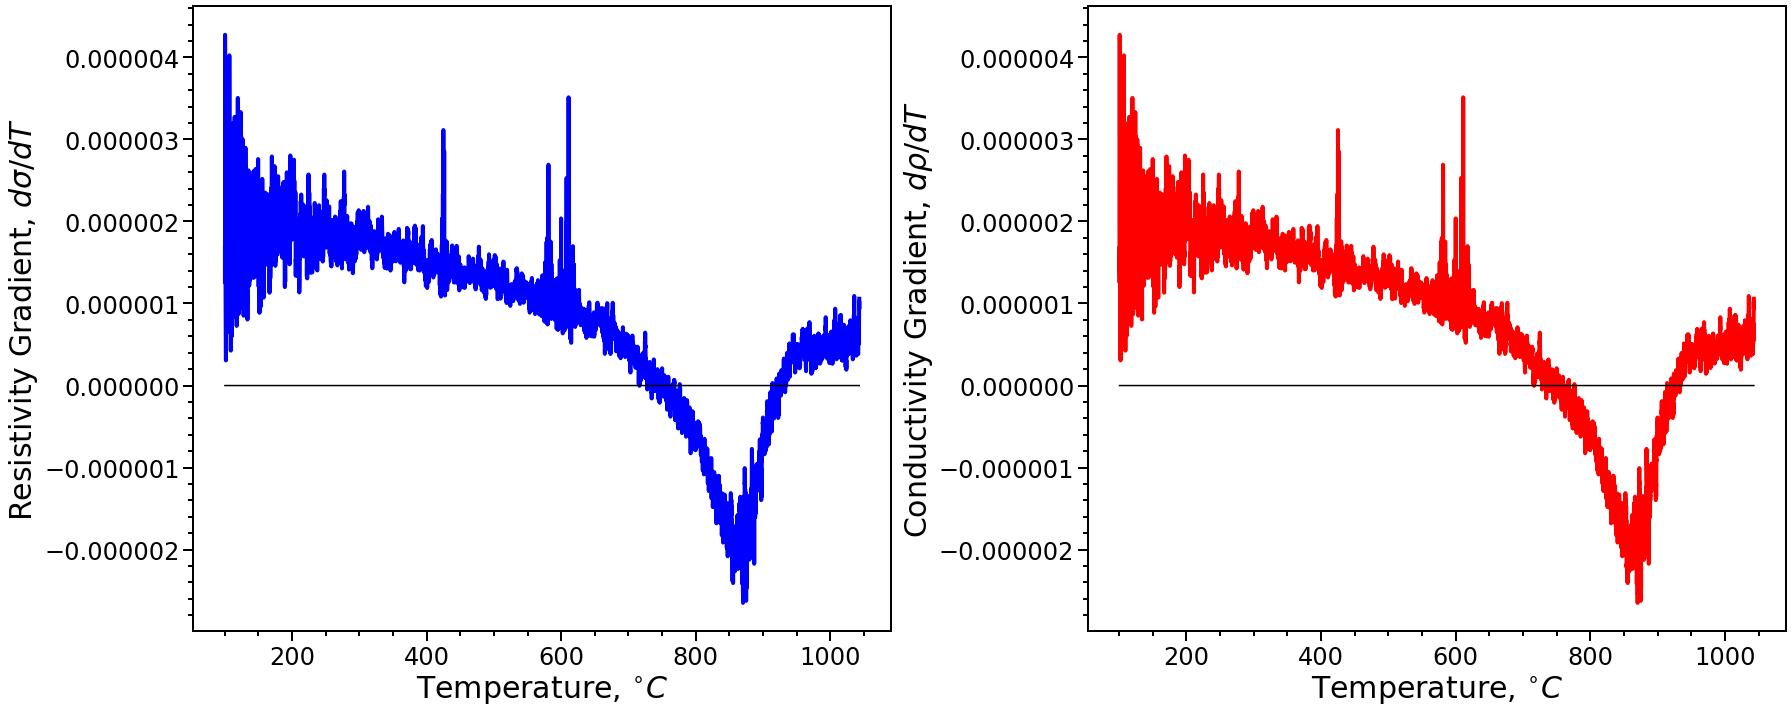

In [9]:
filter_temperature = moving_average(ETMT_data_array[column["temperature"]][start:end], filter_value)
filter_resistivity = moving_average(resistivity[start:end], filter_value)
filter_conductivity = moving_average(conductivity[start:end], filter_value)
resistivity_deriv = np.gradient(filter_resistivity, filter_temperature)
conductivity_deriv = np.gradient(filter_conductivity, filter_temperature)

plt.rc('xtick', labelsize = 24)
plt.rc('ytick', labelsize = 24)
plt.rc('legend', fontsize = 20)
plt.rc('axes', linewidth = 2)
plt.rc('xtick.major', width = 2, size = 10)
plt.rc('xtick.minor', width = 2, size = 5)
plt.rc('ytick.major', width = 2, size = 10)
plt.rc('ytick.minor', width = 2, size = 5)

fig, ((ax1),(ax2)) = plt.subplots(1, 2, figsize = (25, 10))

ax1.minorticks_on()
ax1.plot(filter_temperature[0:end-start-remove_end_points], resistivity_deriv[0:end-start-remove_end_points], color = "blue", linewidth = 4)
ax1.plot(filter_temperature[0:end-start-remove_end_points], np.zeros(end-start-remove_end_points), color = "black")
ax1.set_xlabel(r"Temperature, $^{\circ}C$", fontsize = 30)
ax1.set_ylabel(r"Resistivity Gradient, ${d\sigma/dT}$", fontsize = 30)

ax2.minorticks_on()
ax2.plot(filter_temperature[0:end-start-remove_end_points], resistivity_deriv[0:end-start-remove_end_points], color = "red", linewidth = 4)
ax2.plot(filter_temperature[0:end-start-remove_end_points], np.zeros(end-start-remove_end_points), color = "black")
ax2.set_xlabel(r"Temperature, $^{\circ}C$", fontsize = 30)
ax2.set_ylabel(r"Conductivity Gradient, ${d\rho/dT}$", fontsize = 30)

fig.tight_layout()
#fig.savefig(f"gradient_resisitivity_conductivity.png")

From these plots we manually define the start and end of the alpha to beta transformation;

In [10]:
# identify the approximate start of transition, this value can be altered to better fit the curve and reduce uncertainty
start_transition_value = 650

# identify the the approximate end of transition, this value can be altered to better fit the curve and reduce uncertainty
end_transition_value = 930

Having defined these values we can now fit a cubic function to the alpha-phase behaviour and a linear function to the beta-phase behaviour, and then plot the curves.

In [11]:
absolute_transition_value = np.abs(ETMT_data_array[column["temperature"]][0:end] - start_transition_value)
start_transition_element = absolute_transition_value.argmin()
print("The start of the transition from alpha to beta has been set to a temperature of ", start_transition_value, "which is the ", start_transition_element, "element in the array.")

beta_start = start_transition_element

absolute_transition_value = np.abs(ETMT_data_array[column["temperature"]][0:end] - end_transition_value)
end_transition_element = absolute_transition_value.argmin()
print("The end of the transition from alpha to fully beta has been set to a temperature of ", end_transition_value, "which is the ", end_transition_element, "element in the array.")

alpha_end = end_transition_element

def func_linear(x, a, b):
    return a*x + b
def func_quadratic(x, a, b, c):
    return a*pow(x,2) + b*x + c
def func_cubic(x, a, b, c, d):
    return a*pow(x,3) + b*pow(x,2) + c*x + d

popt_alpha, pcov_alpha = curve_fit(func_cubic, ETMT_data_array[column["temperature"]][start:beta_start], resistivity[start:beta_start])
cubic_fit = func_cubic(ETMT_data_array[column["temperature"]][start:end], *popt_alpha)

popt_beta, pcov_beta = curve_fit(func_linear, ETMT_data_array[column["temperature"]][alpha_end:end], resistivity[alpha_end:end])
linear_fit = func_linear(ETMT_data_array[column["temperature"]][start:end], *popt_beta)

popt_alpha_conductivity, pcov_alpha_conductivity = curve_fit(func_cubic, ETMT_data_array[column["temperature"]][start:beta_start], conductivity[start:beta_start])
cubic_fit_conductivity = func_cubic(ETMT_data_array[column["temperature"]][start:end], *popt_alpha_conductivity)

popt_beta_conductivity, pcov_beta_conductivity = curve_fit(func_linear, ETMT_data_array[column["temperature"]][alpha_end:end], conductivity[alpha_end:end])
linear_fit_conductivity = func_linear(ETMT_data_array[column["temperature"]][start:end], *popt_beta_conductivity)

The start of the transition from alpha to beta has been set to a temperature of  650 which is the  8251 element in the array.
The end of the transition from alpha to fully beta has been set to a temperature of  930 which is the  11438 element in the array.


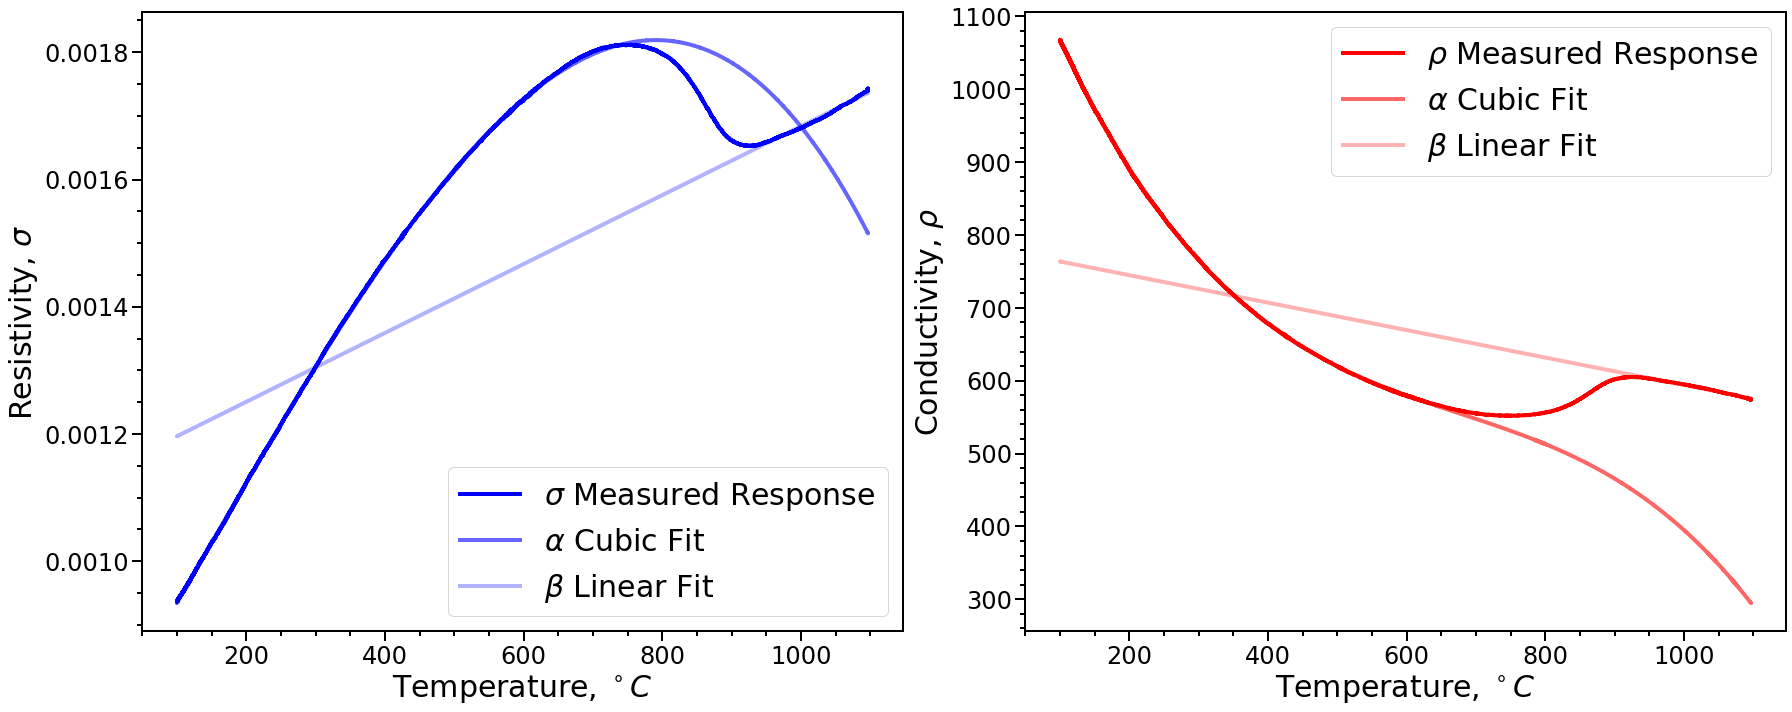

In [12]:
fig, ((ax1),(ax2)) = plt.subplots(1, 2, figsize = (25, 10))

ax1.minorticks_on()
ax1.plot(ETMT_data_array[column["temperature"]][start:end], resistivity[start:end], color = "blue", linewidth = 4, label = r"${\sigma}$ Measured Response")
ax1.plot(ETMT_data_array[column["temperature"]][start:end], cubic_fit, color = "blue", linewidth = 4, alpha = 0.6, label = r"${\alpha}$ Cubic Fit")
ax1.plot(ETMT_data_array[column["temperature"]][start:end], linear_fit, color = "blue", linewidth = 4, alpha = 0.3, label = r"${\beta}$ Linear Fit")
ax1.set_xlabel(r"Temperature, ${^\circ C}$", fontsize = 30)
ax1.set_ylabel(r"Resistivity, ${\sigma}$", fontsize = 30)
ax1.legend(fontsize = 30)

ax2.minorticks_on()
ax2.plot(ETMT_data_array[column["temperature"]][start:end], conductivity[start:end], color = "red", linewidth = 4, label = r"${\rho}$ Measured Response")
ax2.plot(ETMT_data_array[column["temperature"]][start:end], cubic_fit_conductivity, color = "red", linewidth = 4, alpha = 0.6, label = r"${\alpha}$ Cubic Fit")
ax2.plot(ETMT_data_array[column["temperature"]][start:end], linear_fit_conductivity, color = "red", linewidth = 4, alpha = 0.3, label = r"${\beta}$ Linear Fit")
ax2.set_xlabel(r"Temperature, ${^\circ C}$", fontsize = 30)
ax2.set_ylabel(r"Conductivity, ${\rho}$", fontsize = 30)
ax2.legend(fontsize = 30)

fig.tight_layout()
# fig.savefig(f"resisitivity_conductivity_fit.png")

As explained in [1](https://www.research.manchester.ac.uk/portal/en/theses/an-investigation-into-the-texture-development-during-hotrolling-of-dualphase-zirconium-alloys(416cf1d6-15de-41d0-ad7c-3d0db664ae84).html) and [2](https://doi.org/10.1016/0956-7151(95)90259-7) there are two extreme cases for a law of mixtures, with phases either aligned perfectly parrallel, or perfectly perpendicular, to the current. These two instances provide upper and lower bound solutions for the calculated phase fraction.

This means that the upper and lower bound values for the volume fraction of β, in the region where volume fraction changes with temperature, can be determined from the difference between extrapolated fitted response to the low temperature alpha and high temperature beta phases, and from the measured response recorded by the resistivity (or conductivity) data for the composite;

${f_\beta = \frac{\sigma_\alpha - \sigma_c}{\sigma_\alpha - \sigma_\beta}}$

and;

${f_\beta = \frac{\rho_\alpha - \rho_c}{\rho_\alpha - \rho_\beta}}$

In [13]:
sigma_alpha = cubic_fit
sigma_composite = resistivity[start:end]
sigma_beta = linear_fit
beta_fraction_sigma = np.divide(sigma_alpha - sigma_composite, sigma_alpha - sigma_beta)*100

rho_alpha = cubic_fit_conductivity
rho_composite = conductivity[start:end]
rho_beta = linear_fit_conductivity
beta_fraction_rho = np.divide(rho_alpha - rho_composite, rho_alpha - rho_beta)*100

The approach curve can then be plotted by choosing a nice temperature range that covers the start and end of the transition.

In [14]:
# set a nice value for the x-axis (temperature) of the plot before the start of transition
min_approach_curve = 600

# set a nice value for the x-axis (temperature) of the plot before the end of transition
max_approach_curve = 980

In [15]:
def closest (number, array):
    value = array[0]
    for index in range (len(array)):
        if abs (number - array[index]) < abs (number - value):
            value = array[index]
            element = index
    return value, element

The closest minimum temperature for the start of the approach curve is : 599.943079054356 , which is element:  4629
The closest maximum temperature for the end of the approach curve is : 980.028621386737 , which is element:  8827


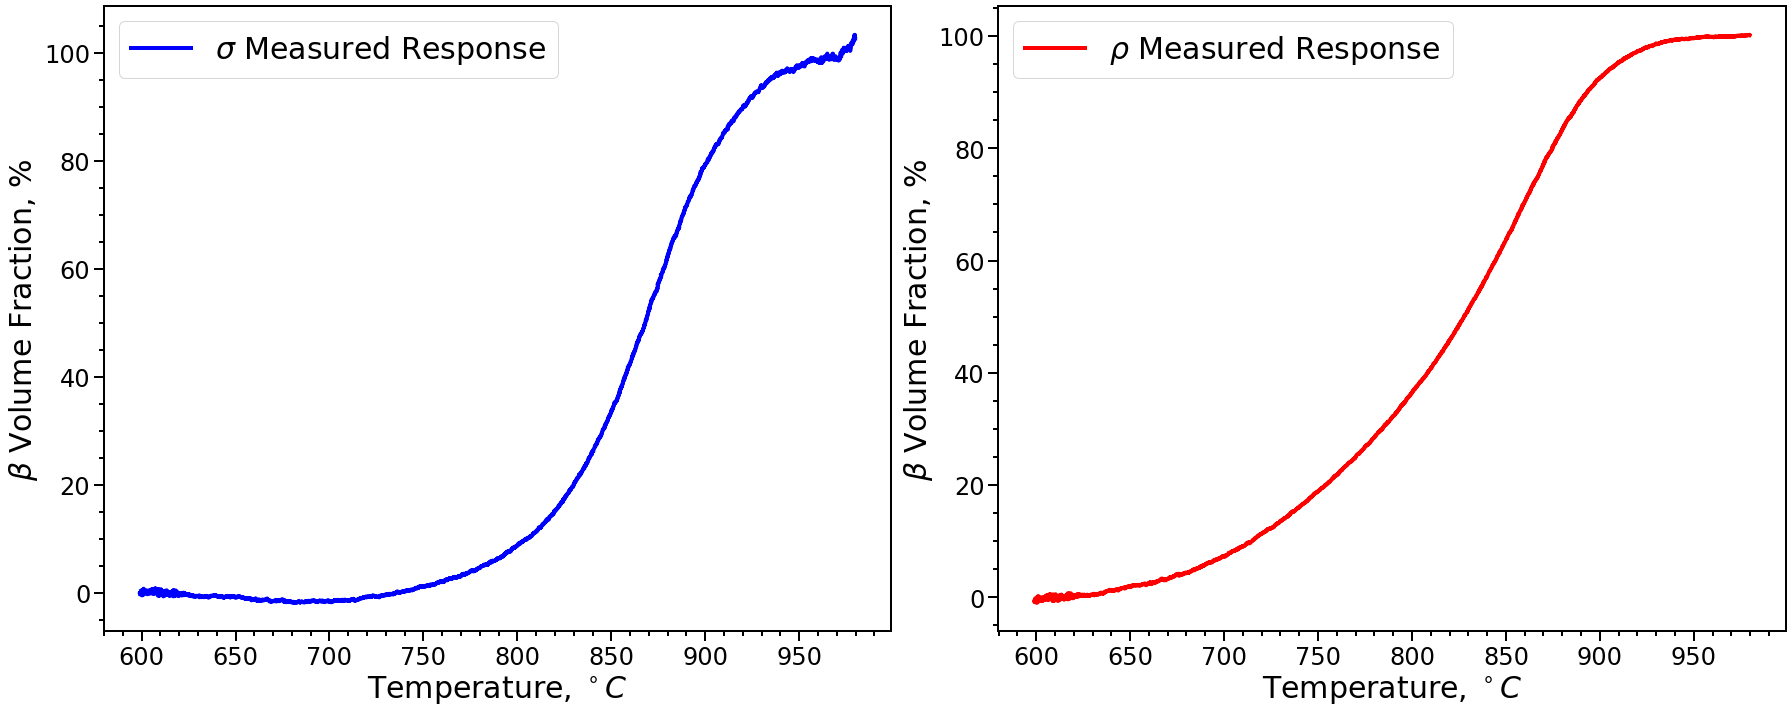

In [16]:
min_approach_value, min_approach_element = closest(min_approach_curve, ETMT_data_array[column["temperature"]][start:end])
max_approach_value, max_approach_element = closest(max_approach_curve, ETMT_data_array[column["temperature"]][start:end])

print("The closest minimum temperature for the start of the approach curve is :", min_approach_value, ", which is element: ", min_approach_element)
print("The closest maximum temperature for the end of the approach curve is :", max_approach_value, ", which is element: ", max_approach_element)

fig, ((ax1),(ax2)) = plt.subplots(1, 2, figsize = (25, 10))

ax1.minorticks_on()
ax1.plot(ETMT_data_array[column["temperature"]][min_approach_element+start:max_approach_element+start],beta_fraction_sigma[min_approach_element:max_approach_element], color = "blue", linewidth = 4, label = r"${\sigma}$ Measured Response")
ax1.set_xlabel(r"Temperature, ${^\circ C}$", fontsize = 30)
ax1.set_ylabel(r"${\beta}$ Volume Fraction, %", fontsize = 30)
ax1.legend(fontsize = 30)

ax2.minorticks_on()
ax2.plot(ETMT_data_array[column["temperature"]][min_approach_element+start:max_approach_element+start],beta_fraction_rho[min_approach_element:max_approach_element], color = "red", linewidth = 4, label = r"${\rho}$ Measured Response")
ax2.set_xlabel(r"Temperature, ${^\circ C}$", fontsize = 30)
ax2.set_ylabel(r"${\beta}$ Volume Fraction, %", fontsize = 30)
ax2.legend(fontsize = 30)

fig.tight_layout()
# fig.savefig(f"beta_approach_original.png")

Importantly, note that the bigger the difference between the two methods (resistivity and conductivity), the larger the uncertainty in the phase fraction.

Uncertainty can be reduced by better fitting of the curves, and adjusting the `start_transition_value` and `end_transition_value` above through to see which values give the best fit. Uncertainty in the experiment can also be reduced by better welding the thermocouple and resistivity wires to the sample, and by running lots of tests to verify the results.

### Adjusting the Beta Approach Curve for Two-Phase Alloys

The above will work fine for single-phase Zr and Ti alloys, since they transform from fully alpha to fully beta. However, for two-phase alloys such as Zr-2.5Nb and Ti-64, there is a residual amount of beta-phase at room temperature and so the volume fractions must be adjusted to account for this, to represent the true change in ${\beta}$ phase fraction.

Typically these industrially-used two-phase alloys contain 10% beta-phase fraction at room temperature, but this value should be checked using microstructural or X-ray diffraction studies to verify the exact phase compostion of the alloy at room temperature.

In [17]:
# define the starting beta-phase fraction of the material, typically 10% in Zr-2.5Nb and Ti-64
RT_beta_fraction = 10

# define the maximum beta-phase fraction of the material, typically 100% can be reached in Zr-2.5Nb and Ti-64
max_beta_fraction = 100

In [18]:
# calculate ideal difference between maximum and minimum beta fraction
ideal_beta_fraction_diff = max_beta_fraction - RT_beta_fraction
# calculate current difference between maximum and minimum beta fraction
current_beta_fraction_diff_sigma = beta_fraction_sigma[max_approach_element] - beta_fraction_sigma[min_approach_element]
current_beta_fraction_diff_rho = beta_fraction_rho[max_approach_element] - beta_fraction_rho[min_approach_element]

# calculate adjustment factor for beta approach curve
adjust_ratio_sigma = ideal_beta_fraction_diff / current_beta_fraction_diff_sigma
adjust_ratio_rho = ideal_beta_fraction_diff / current_beta_fraction_diff_rho

# calculate correction needed to make adjusted beta approach curve reach 100% beta
max_beta_fraction_adjusted_sigma = beta_fraction_sigma[max_approach_element] * adjust_ratio_sigma
intercept_sigma = max_beta_fraction - max_beta_fraction_adjusted_sigma

max_beta_fraction_adjusted_rho = beta_fraction_rho[max_approach_element] * adjust_ratio_rho
intercept_rho = max_beta_fraction - max_beta_fraction_adjusted_rho

# calculate corrected beta approach curve
beta_fraction_adjusted_sigma = (beta_fraction_sigma * adjust_ratio_sigma) + intercept_sigma
beta_fraction_adjusted_rho = (beta_fraction_rho * adjust_ratio_rho) + intercept_rho

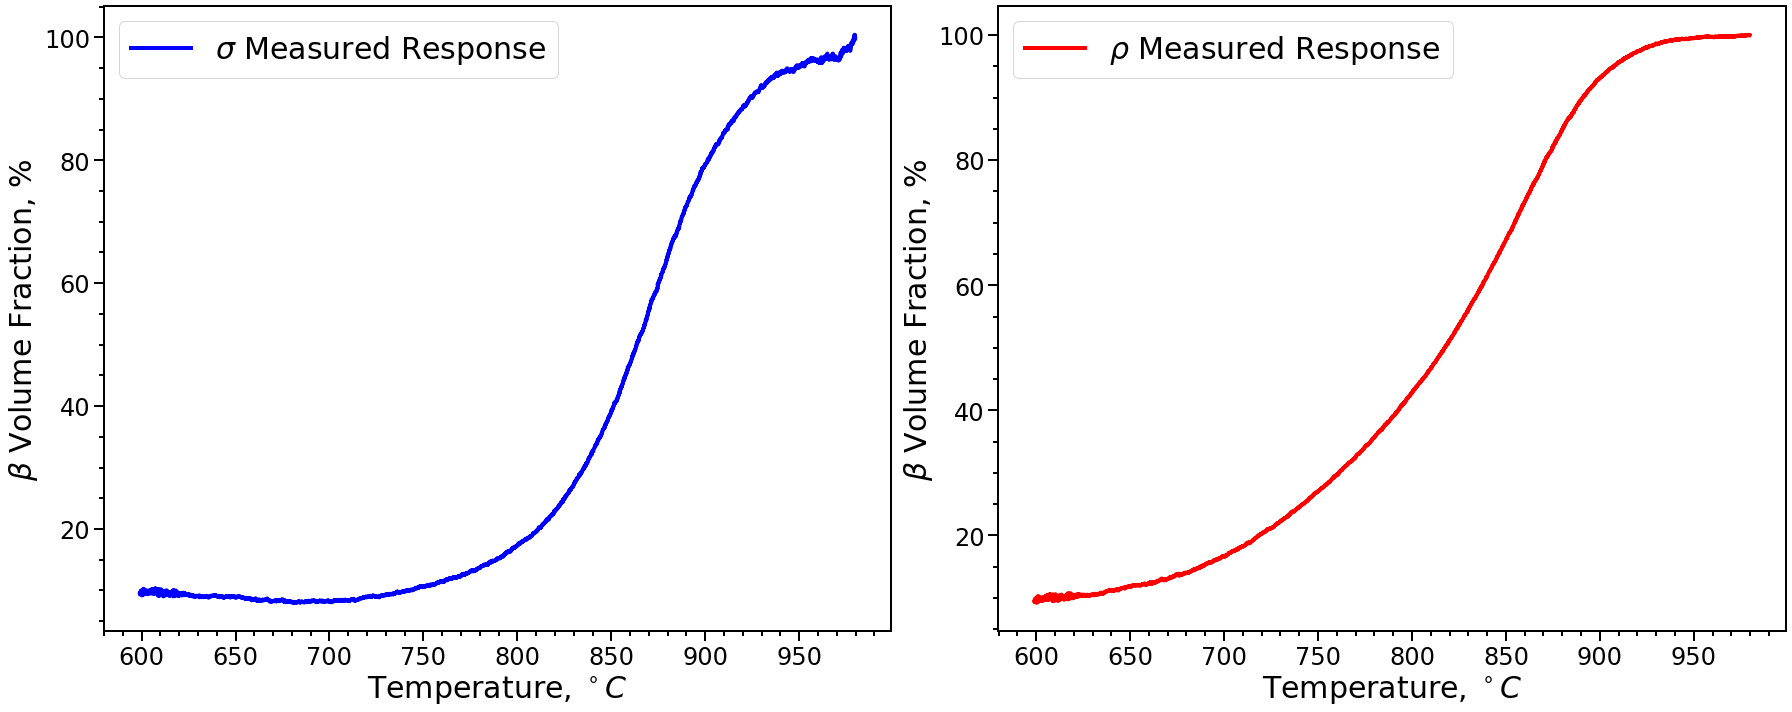

In [19]:
fig, ((ax1),(ax2)) = plt.subplots(1, 2, figsize = (25, 10))

ax1.minorticks_on()
ax1.plot(ETMT_data_array[column["temperature"]][min_approach_element+start:max_approach_element+start],beta_fraction_adjusted_sigma[min_approach_element:max_approach_element], color = "blue", linewidth = 4, label = r"${\sigma}$ Measured Response")
ax1.set_xlabel(r"Temperature, ${^\circ C}$", fontsize = 30)
ax1.set_ylabel(r"${\beta}$ Volume Fraction, %", fontsize = 30)
ax1.legend(fontsize = 30)

ax2.minorticks_on()
ax2.plot(ETMT_data_array[column["temperature"]][min_approach_element+start:max_approach_element+start],beta_fraction_adjusted_rho[min_approach_element:max_approach_element], color = "red", linewidth = 4, label = r"${\rho}$ Measured Response")
ax2.set_xlabel(r"Temperature, ${^\circ C}$", fontsize = 30)
ax2.set_ylabel(r"${\beta}$ Volume Fraction, %", fontsize = 30)
ax2.legend(fontsize = 30)

fig.tight_layout()
# fig.savefig(f"beta_approach_adjusted.png")

Finally, we can combine the beta approach curve calculated from resistivity and conductivity measurements, to produce a single plot of the phase fraction for our two-phase alloy, which accounts for any uncertainty in the method.

This gives us out final ${\beta}$ approach curve.

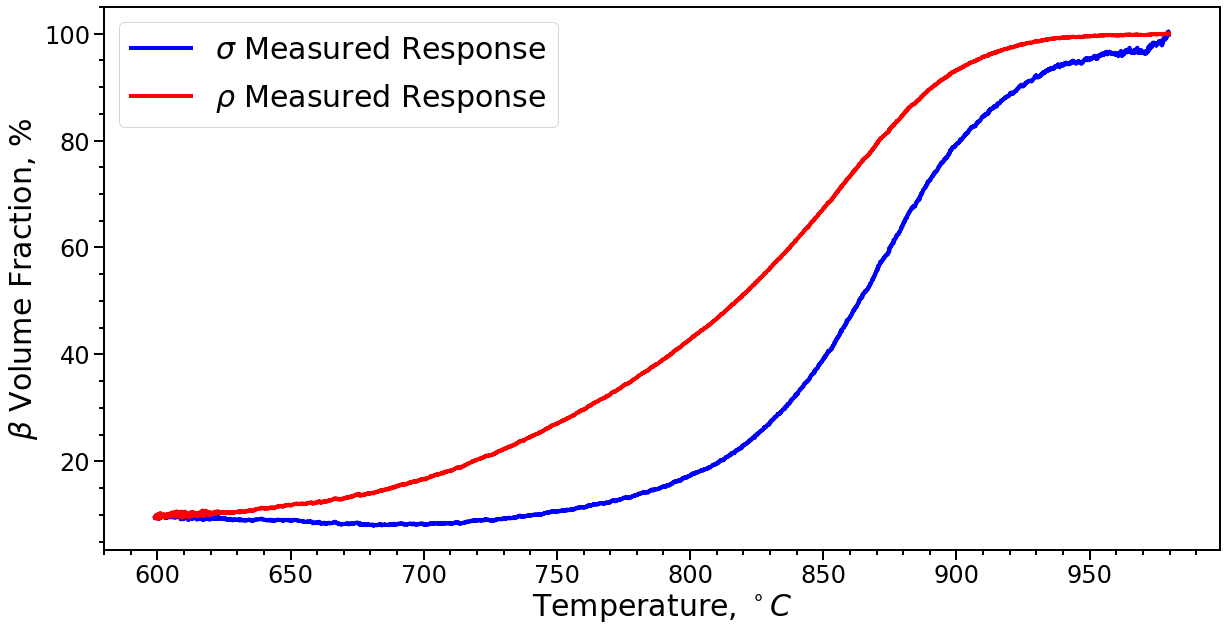

In [20]:
plt.figure(figsize = (20, 10))
plt.minorticks_on()
plt.plot(ETMT_data_array[column["temperature"]][min_approach_element+start:max_approach_element+start],beta_fraction_adjusted_sigma[min_approach_element:max_approach_element], color = "blue", linewidth = 4, label = r"${\sigma}$ Measured Response")
plt.plot(ETMT_data_array[column["temperature"]][min_approach_element+start:max_approach_element+start],beta_fraction_adjusted_rho[min_approach_element:max_approach_element], color = "red", linewidth = 4, label = r"${\rho}$ Measured Response")
plt.xlabel(r"Temperature, ${^\circ C}$", fontsize = 30)
plt.ylabel(r"${\beta}$ Volume Fraction, %", fontsize = 30)
plt.legend(fontsize = 30)

fig.tight_layout()
# fig.savefig(f"beta_approach_combined.png")